# Tokyo Airbnb Price Prediction - Comparision of Gradient Boosting and Deep Learning

This notebook contains the code to accompany chapter 12 of [Machine Learning with Tabular Data](https://www.manning.com/books/machine-learning-on-tabular-data). In this code we compare the [XGBoost solution to the Tokyo Airbnb price prediction problem](https://github.com/lmassaron/ml_on_tabular_data/blob/main/chapter_07/chapter_07.ipynb) adapted from chapter 7 with a fastai solution.

In [1]:
# ingest the Airbnb Tokyo dataset
import pandas as pd
url = "https://raw.githubusercontent.com/lmassaron/tabular_datasets/master/airbnb_tokyo.csv"
airbnb_tokyo = pd.read_csv(url)

In [2]:
y = airbnb_tokyo["target"]
X = airbnb_tokyo.iloc[:, :-1].set_index("listing_id")

In [3]:
# list columns in the dataset
X.columns

Index(['onehot_encoding__room_type_Entire home/apt',
       'onehot_encoding__room_type_Hotel room',
       'onehot_encoding__room_type_Private room',
       'onehot_encoding__room_type_Shared room',
       'ordinal_encoding__neighbourhood_more_than_30',
       'ordinal_encoding__type_of_accommodation',
       'target_encoding__coordinates', 'numeric__minimum_nights',
       'numeric__number_of_reviews', 'numeric__days_since_last_review',
       'numeric__reviews_per_month', 'numeric__calculated_host_listings_count',
       'numeric__availability_365', 'numeric__score',
       'numeric__number_of_reviews_ltm',
       'numeric__number_of_reviews_ltm_ratio', 'numeric__number_of_bedrooms',
       'numeric__number_of_beds', 'numeric__number_of_baths',
       'numeric__imperial_palace_distance',
       'numeric__nearest_convenience_store', 'numeric__nearest_train_station',
       'numeric__nearest_airport', 'numeric__nearest_bus_station',
       'numeric__nearest_subway', 'binary__is_new', 

In [4]:
# Define a five-fold stratified random splitting using sklearn Stratified K-Folds cross-validator
from sklearn.model_selection import StratifiedKFold

neighbourhood_more_than_30 = X["ordinal_encoding__neighbourhood_more_than_30"].astype(int)
cv = StratifiedKFold(5, shuffle=True, random_state=0) #A



In [5]:
# define values for the XGBoost hyperparameters
xgb_params = {'booster': 'gbtree',
              'colsample_bytree': 0.946407058507176,
              'learning_rate': 0.06867015067874482,
              'max_depth': 7,
              'min_child_weight': 5,
              'n_estimators': 901,
              'objective': 'reg:tweedie',
              'reg_alpha': 0.0006368936493084075,
              'reg_lambda': 3.8302865696045996,
              'subsample': 0.8956307610431394,
              'tweedie_variance_power': 1.560801988491813}

In [6]:
# define and train the XGBoost model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import numpy as np

xgb = XGBRegressor(**xgb_params) #A

cv_splits = cv.split(X, y=neighbourhood_more_than_30) #B

r2_scores = []
rmse_scores = []
mae_scores = []
xgb_oof_preds = np.zeros(len(X))

for train_index, test_index in cv_splits: #C
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test) #D
    xgb_oof_preds[test_index] = y_pred

    r2_scores.append(r2_score(y_test, y_pred)) #E
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))

print(f"Mean cv R-squared: {np.mean(r2_scores):.3f}") #F
print(f"Mean cv RMSE: {np.mean(rmse_scores):.3f}")
print(f"Mean cv MAE: {np.mean(mae_scores):.3f}")

#A set up an XGBoost regressor with the specified hyperparameters
#B define cross-validation splits based on the neighbourhood_more_than_30 feature
#C generate cross-validation splits based on the neighbourhood_more_than_30 feature
#D perform cross-validated predictions
#E calculate R-squared, RMSE, and MAE evaluation metrics to assess the model's performance
#F print the range of predicted values


Mean cv R-squared: 0.728
Mean cv RMSE: 10862.488
Mean cv MAE: 6555.985


In [7]:
from fastai.tabular.all import *
pd.options.mode.chained_assignment=None

In [8]:
# set the pipeline parameters for the fastai model
procs = [FillMissing, Normalize, Categorify]

cat_vars = [col for col in airbnb_tokyo.columns if "onehot_encoding__" in col or "ordinal_encoding__" in col or "binary__" in col]
cont_vars = [col for col in airbnb_tokyo.columns if "numeric__" in col or "target_encoding__" in col]
dep_var = 'target'

In [9]:
# define and train the fastai model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

cv_splits = cv.split(X, y=neighbourhood_more_than_30) #B

r2_scores = []
rmse_scores = []
mae_scores = []
dnn_oof_preds = np.zeros(len(X))

for k, (train_index, test_index) in enumerate(cv_splits): #C
    X_train = airbnb_tokyo.set_index("listing_id").iloc[train_index].copy()
    X_test = airbnb_tokyo.set_index("listing_id").iloc[test_index].copy()
    y_test = airbnb_tokyo["target"].iloc[test_index].copy()

    tab = TabularPandas(X_train, procs, cat_vars, cont_vars, dep_var, y_block=RegressionBlock(),
                        splits=RandomSplitter(valid_pct=0.2, seed=0)(range_of(X_train)),
                        inplace=True, reduce_memory=True)

    dls = tab.dataloaders(bs=128)
    y_range = torch.tensor([0, X_train['target'].max() * 1.2])
    tc = tabular_config(ps=[0.001, 0.01], embed_p=0.04, y_range=y_range)
    learn = tabular_learner(dls, layers=[1000,500],
                            metrics=mae,
                            config=tc,
                            loss_func=L1LossFlat())
    with learn.no_bar(), learn.no_logging():
        lr = learn.lr_find(show_plot=False)
        learn.fit_one_cycle(80, lr.valley)

    dl = learn.dls.test_dl(X_test)
    y_pred = learn.get_preds(dl=dl)[0].numpy().ravel()
    dnn_oof_preds[test_index] = y_pred

    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    print(f"CV Fold {k} MAE: {mae_scores[-1]:.3f}")

print(f"\nMean cv R-squared: {np.mean(r2_scores):.3f}")
print(f"Mean cv RMSE: {np.mean(rmse_scores):.3f}")
print(f"Mean cv MAE: {np.mean(mae_scores):.3f}")

Output hidden; open in https://colab.research.google.com to view.

In [10]:
corr = np.corrcoef(xgb_oof_preds, dnn_oof_preds)[0][1]
print(f"Correlation XGBoost & DNN = {corr:.3f}")

Correlation XGBoost & DNN = 0.918


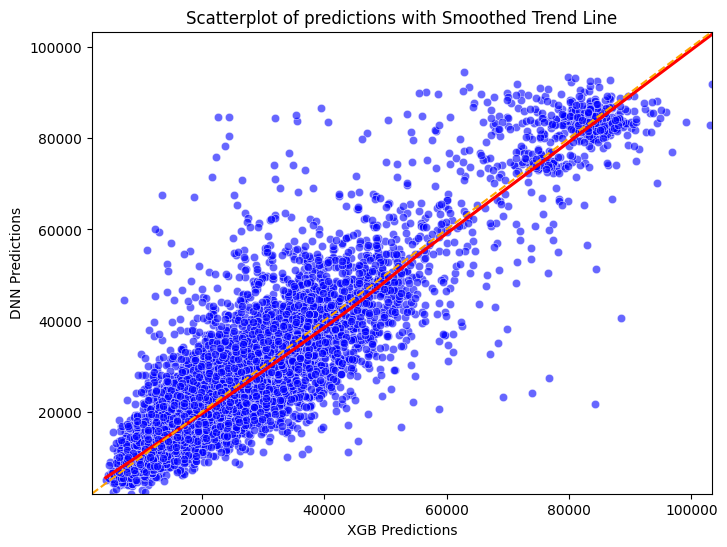

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=xgb_oof_preds, y=dnn_oof_preds, color='blue', alpha=0.6)

# Add a smoothed trend line
sns.regplot(x=xgb_oof_preds, y=dnn_oof_preds, scatter=False, color='red', lowess=True)

# Find the common minimum and maximum values
min_val = min(np.min(xgb_oof_preds), np.min(dnn_oof_preds))
max_val = max(np.max(xgb_oof_preds), np.max(dnn_oof_preds))

# Add the diagonal line
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='orange')

# Add labels and a title
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.xlabel('XGB Predictions')
plt.ylabel('DNN Predictions')
plt.title('Scatterplot of predictions with Smoothed Trend Line')

# Show the plot
plt.show()

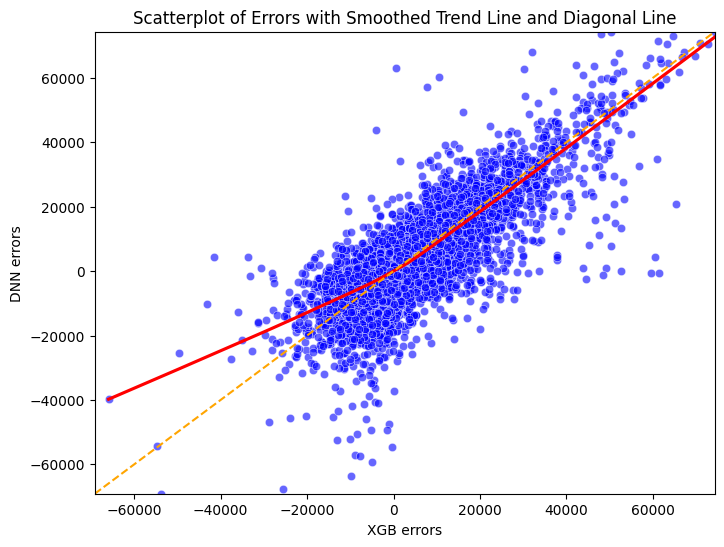

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the differences
xgb_errors = y - xgb_oof_preds
dnn_errors = y - dnn_oof_preds

# Find the common minimum and maximum values
min_val = min(np.min(xgb_errors), np.min(dnn_errors))
max_val = max(np.max(xgb_errors), np.max(dnn_errors))

# Create a scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=xgb_errors, y=dnn_errors, color='blue', alpha=0.6)

# Add a smoothed trend line
sns.regplot(x=xgb_errors, y=dnn_errors, scatter=False, color='red', lowess=True)

# Add the diagonal line
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='orange')

# Set both axes to the common minimum and maximum values
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Add labels and a title
plt.xlabel('XGB errors')
plt.ylabel('DNN errors')
plt.title('Scatterplot of Errors with Smoothed Trend Line and Diagonal Line')

# Show the plot
plt.show()

In [13]:
# get ensembled predictions
blend_list = [[1.0, 0.0], [0.75, 0.25], [0.5, 0.5], [0.25, 0.75], [0.0, 1.0]]
for a, b in blend_list:
    print(f"XGboost weight={a}, DNN weight={b}")
    blended_oof_preds = xgb_oof_preds * a + dnn_oof_preds * b
    r2 = r2_score(blended_oof_preds, y)
    rmse = np.sqrt(mean_squared_error(blended_oof_preds, y))
    mae = mean_absolute_error(blended_oof_preds, y)
    print(f"blended result for R-squared: {r2:.3f}")
    print(f"blended result for RMSE: {rmse:.3f}")
    print(f"blended result for MAE: {mae:.3f}\n")

XGboost weight=1.0, DNN weight=0.0
blended result for R-squared: 0.599
blended result for RMSE: 10863.943
blended result for MAE: 6555.976

XGboost weight=0.75, DNN weight=0.25
blended result for R-squared: 0.616
blended result for RMSE: 10584.198
blended result for MAE: 6396.232

XGboost weight=0.5, DNN weight=0.5
blended result for R-squared: 0.619
blended result for RMSE: 10602.265
blended result for MAE: 6413.418

XGboost weight=0.25, DNN weight=0.75
blended result for R-squared: 0.610
blended result for RMSE: 10916.664
blended result for MAE: 6607.757

XGboost weight=0.0, DNN weight=1.0
blended result for R-squared: 0.589
blended result for RMSE: 11503.123
blended result for MAE: 6999.112

